# CME538 - Introduction to Data Science
## Tutorial 11 - Decision Trees, Random Forests, and Pipelines
By Navid Kayhani

### Overview 
In this tutorial, we will revisit the problem of Email Spam Classification that you previously saw in Assignment 8. In the first part, we aim to train a set of models to classify emails as `spam` or `not-spam`. In the second part, we see how we can create Machine Learning pipelines to make our code ready for production. 
### Learning Objectives

- #### Part 1 
- Decision Trees
- Random Forests
- #### Part 2
- Productionization
- ML Pipelines




## Setup Notebook

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Generate confusion matrix
from sklearn.metrics import confusion_matrix, f1_score
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import plot_confusion_matrix, classification_report

#Random Forest 
from sklearn.ensemble import RandomForestClassifier

#Logestic Regresion
from sklearn.linear_model import LogisticRegression
#Metrics

#model selection
from sklearn.model_selection import StratifiedKFold

# Configure Notebook
#for plots to be inline
%matplotlib inline 
#for auto_complete 
%config Completer.use_jedi = False 
# import warnings

# warnings.filterwarnings('ignore')
plt.style.use('fivethirtyeight')
sns.set_context("notebook")

# Part 1

## The Data
The data can be found in the file `emails.csv` next to this notebook. The `csv` contains the following columns.

Columns of `emails.csv` include:
- `id`: An identifier for the training example
- `subject`: The subject of the email
- `email`:  The text of the email
- `label`: 1 if the email is `spam`, 0 if the email is `not-spam`

The file `emails.csv` contains 7513 rows where each row is an email.

First, let's import `emails.csv` to a DataFrame.

In [2]:
email_data = ...
email_data.head()

,id,subject,email,label
4282,4282,Subject: RE: [ILUG] Dell GX260 V Redhat 7.3\n,> When I get a box I don't want any of that in...,0
6293,6293,Subject: IBM eNews: Aktuelle Informationen von...,"IBM eNews\n 4. Juli 2002\n \n Liebe Leserin, l...",0
2349,2349,"Subject: [zzzzteana] Height, weight, girth, etc\n","http://www.guardian.co.uk/uk_news/story/0,3604...",0
3786,3786,Subject: Re: The GOv gets tough on Net Users.....,Hire a really talented skywriter to doodle nud...,0
4731,4731,Subject: Lander risks missing Mars trip\n,"URL: http://www.newsisfree.com/click/-4,805285...",0


# 1. Data Cleaning and Pre-processing
First, let's convert the email and subject text to lower case. This is based on the assumption that what differentiates `spam` emails from `not-spam` emails is case-insensitive.

Next, let's check if our data contains any missing values. 

### Missing Values and Imputation

In [3]:
print('Missingness before imputation:')
print(...)

Missingness before imputation:
id         0
subject    6
email      0
label      0
dtype: int64


We can see there are 6 missing values for `'subject'`. This means that a subject was not included in the email and therefore, we can we replace missing values with appropriate filler values (i.e., NaN values in the subject or email columns will be replaced with empty strings `''`).

In [4]:
email_data[['subject', 'email']] = ...
print('Missingness after imputation:')
print(...)

Missingness after imputation:
id         0
subject    0
email      0
label      0
dtype: int64


In [5]:
email_data.head()

,id,subject,email,label
4282,4282,Subject: RE: [ILUG] Dell GX260 V Redhat 7.3\n,> When I get a box I don't want any of that in...,0
6293,6293,Subject: IBM eNews: Aktuelle Informationen von...,"IBM eNews\n 4. Juli 2002\n \n Liebe Leserin, l...",0
2349,2349,"Subject: [zzzzteana] Height, weight, girth, etc\n","http://www.guardian.co.uk/uk_news/story/0,3604...",0
3786,3786,Subject: Re: The GOv gets tough on Net Users.....,Hire a really talented skywriter to doodle nud...,0
4731,4731,Subject: Lander risks missing Mars trip\n,"URL: http://www.newsisfree.com/click/-4,805285...",0


### Lower case

In [6]:
email_data['subject'] = ..
email_data['email'] = ...
email_data.head()

,id,subject,email,label
4282,4282,subject: re: [ilug] dell gx260 v redhat 7.3\n,> when i get a box i don't want any of that in...,0
6293,6293,subject: ibm enews: aktuelle informationen von...,"ibm enews\n 4. juli 2002\n \n liebe leserin, l...",0
2349,2349,"subject: [zzzzteana] height, weight, girth, etc\n","http://www.guardian.co.uk/uk_news/story/0,3604...",0
3786,3786,subject: re: the gov gets tough on net users.....,hire a really talented skywriter to doodle nud...,0
4731,4731,subject: lander risks missing mars trip\n,"url: http://www.newsisfree.com/click/-4,805285...",0


In [7]:
def word_detector(words, texts):
    
    """
    Returns a DataFrame with detections of words.

    Parameters:
        words (list): A list of words to look for.
        texts (Series): A series of strings to search in.

    Returns:
        (DataFrame): A DataFrame with len(words) columns and texts.shape[0] rows.
    """
    
    # Write your code here
    detections = 1 * np.array([texts.str.contains(word) for word in words]).T
                                  
    return pd.DataFrame(index=texts.index, data=detections, columns=words)

## Split Data

Lastly, let's split `email_data` into training and test datasets. We'll need this test data to assess the performance of our classifier once we are finished training. Note that we have set the seed (random_state) to `0`. This will produce a pseudo-random sequence of random numbers that is the same every time you run the code.

You'll notice that we've added an argument for `'stratify'` and set it equal to our training target `'label'`. This is done to maintain the proportion of each class in `train` and `test`. If 20% of the emails are `spam` in the dataset, then we want 20% of the emails in the `train` and `test` datasets to be also be `spam`.

In [8]:
from sklearn.model_selection import train_test_split
train, test = ...
print('Train:', train.shape, 'Test:', test.shape)
print('Train spam proportion: {:.2f} %'.format(train['label'][train['label'] == 1].shape[0] / train.shape[0] * 100))
print('Test spam proportion: {:.2f} %'.format(test['label'][test['label'] == 1].shape[0] / test.shape[0] * 100))

Train: (6761, 4) Test: (752, 4)
Train spam proportion: 25.63 %
Test spam proportion: 25.66 %


In [9]:
train.head()

,id,subject,email,label
6277,6277,subject: [spambayes] maybe change x-spam-dispo...,"\n >> accordingly, i wrote unheader.py, wh...",0
2342,2342,subject: perl programmers are so cute\n,url: http://diveintomark.org/archives/2002/10/...,0
3147,3147,subject: sun\n,"well, it looks like sun are going ahead with\n...",0
643,643,subject: [spambayes] spambayes package?\n,\n >> before we get too far down this road...,0
7128,7128,subject: re: use of base image / delta image f...,"> ben mord said:\n > \n > >ah. in that case, y...",0


# 2. Feature Engineering
We would like to take the text of an email and predict whether the email is `spam` or `not-spam`. This is a classification problem and we will be using `decision tree` and `random forest` to train a classifier. The data here is unstructured text and not numbers. Therefore, we will need to extract some numeric features from the raw email text. 

####  Text feature extraction

In [10]:
words = ['drug', 'bank', 'prescription', 'memo', 'private', 
         'body', 'business', 'html', 'money', 'offer', 'please']

# Write your code here
X_train = ...
y_train = ...

In [11]:
X_train.head()

,drug,bank,prescription,memo,private,body,business,html,money,offer,please
6277,0,0,0,0,0,0,0,0,0,0,1
2342,0,0,0,0,0,0,0,1,0,0,0
3147,0,1,0,0,0,0,1,0,0,0,0
643,0,0,0,0,0,0,0,0,0,0,0
7128,0,0,0,0,0,0,0,0,0,0,0


In [12]:
y_train.head()

,label
6277,0
2342,0
3147,0
643,0
7128,0


# 2. Model Building


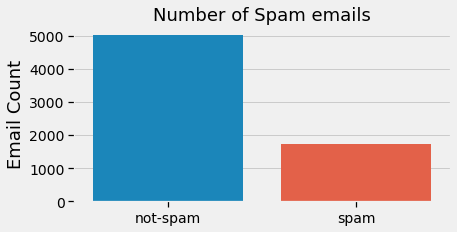

In [13]:
df_temp = ...

plt.figure(figsize=(6, 3))
plt.title('Number of Spam emails', fontsize=18)
ax = sns.countplot(x='label', data=df_temp)
ax.xaxis.set_tick_params(labelsize=14)
ax.yaxis.set_tick_params(labelsize=14)
ax.set_xlabel('', fontsize=18)
ax.set_ylabel('Email Count', fontsize=18)
plt.show()

###  Logistic Regression

In [14]:
log_reg = ...
model_log_reg = ...

C:\Users\nkayf\anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


In [15]:
print(...)

              precision    recall  f1-score   support

           0       0.85      0.94      0.89      5028
           1       0.75      0.53      0.62      1733

    accuracy                           0.83      6761
   macro avg       0.80      0.74      0.76      6761
weighted avg       0.83      0.83      0.82      6761



f_score = 0.6228513650151668


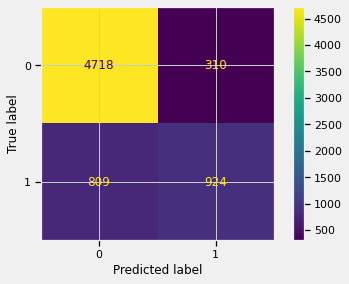

In [16]:
plot_confusion_matrix(...)
print(f'f_score = {f1_score(...)}')

### Decision Tree

In [17]:
from sklearn import tree

# Create Decision Tree classifer object
tree = ...

# Train Decision Tree Classifer
model_tree = ...

In [18]:
print(...)

              precision    recall  f1-score   support

           0       0.90      0.94      0.92      5028
           1       0.81      0.68      0.74      1733

    accuracy                           0.88      6761
   macro avg       0.85      0.81      0.83      6761
weighted avg       0.87      0.88      0.87      6761



f_score = 0.7417135709818636


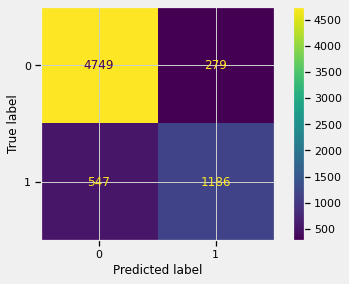

In [19]:
plot_confusion_matrix(...)
print(f'f_score = {f1_score(...)}')

### Random Forest

In [20]:
from sklearn.ensemble import RandomForestClassifier

In [21]:
from sklearn import tree

# Create Random Forest classifer object
forest = ...

# Train Random Forest Classifer
model_forest = ...

<ipython-input-21-3da301193c47>:7: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model_forest = forest.fit(X_train,y_train)


In [22]:
print(classification_report(...)

              precision    recall  f1-score   support

           0       0.90      0.94      0.92      5028
           1       0.81      0.69      0.74      1733

    accuracy                           0.88      6761
   macro avg       0.85      0.82      0.83      6761
weighted avg       0.87      0.88      0.87      6761



f_score = 0.7423580786026202


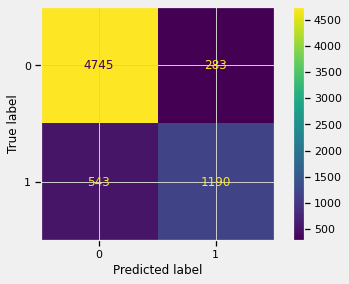

In [23]:
plot_confusion_matrix(...)
print(f'f_score = {f1_score(...)}')

Although, we improved our model. It seems them models are still biased. Maybe revising the features could be helpful. But, let's move on for now. 

## Evaluating Classifiers

In [24]:
X_test = ...
y_test = ...

In [25]:
X_test.head()

,drug,bank,prescription,memo,private,body,business,html,money,offer,please
2565,0,0,0,0,0,1,0,1,0,0,1
4354,0,0,0,0,0,1,0,1,0,1,1
5561,0,0,0,0,0,0,1,0,1,0,1
7323,0,0,0,0,0,0,0,0,0,0,0
3920,0,0,0,0,0,0,0,0,0,0,0


In [26]:
y_pred_tree = ...

In [27]:
y_pred_forest = ...

In [28]:
y_pred_log_reg = ...

In [29]:
y_test = ...

LogisticRegression()
f_score = 0.6407185628742514


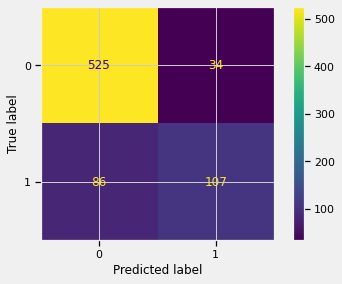

In [30]:
print(model_log_reg)
plot_confusion_matrix(model_log_reg,X_test,y_test)
print(f'f_score = {f1_score(y_test, y_pred_log_reg)}')

In [31]:
print(model_tree)
print(classification_report(y_test, y_pred_tree))

DecisionTreeClassifier()
              precision    recall  f1-score   support

           0       0.89      0.92      0.91       559
           1       0.75      0.68      0.72       193

    accuracy                           0.86       752
   macro avg       0.82      0.80      0.81       752
weighted avg       0.86      0.86      0.86       752



DecisionTreeClassifier()
f_score = 0.717391304347826


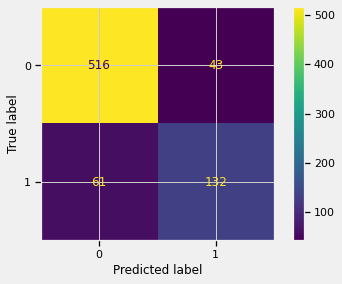

In [32]:
print(model_tree)
plot_confusion_matrix(model_tree,X_test,y_test)
print(f'f_score = {f1_score(y_test, y_pred_tree)}')

In [33]:
print(model_forest)
print(classification_report(y_test, y_pred_forest))

RandomForestClassifier(random_state=0)
              precision    recall  f1-score   support

           0       0.90      0.92      0.91       559
           1       0.76      0.71      0.73       193

    accuracy                           0.87       752
   macro avg       0.83      0.82      0.82       752
weighted avg       0.87      0.87      0.87       752



RandomForestClassifier(random_state=0)
f_score = 0.7345844504021448


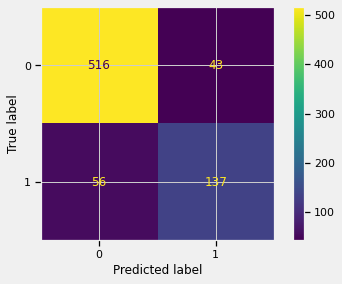

In [34]:
print(model_forest)
plot_confusion_matrix(model_forest,X_test,y_test)
print(f'f_score = {f1_score(y_test, y_pred_forest)}')

# Part 2: ML Pipeline

Now that we are satisfied with the model we trained, how can we prepare our code for production? We can't run the whole notebook every time, can we?

#### In this part we want to answer the following questions:

1. What are pipelines and how to create them?
2. How to save and load models?
3. How to use models for inference? 

### ML Projects' Life Cycle 

<br>
<img src="images/MLLC.png" width = 700/>
<br>


Let's focus on how we could prepare our code for production.

<br>
<img src="images/Classifcation.png" width = 700 />
<br>


In [35]:
import model

C:\Users\nkayf\Desktop\Myrepo\CIV1498-winter-2021-material-private\tutorials\tutorial10\model.py:44: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model = forest.fit(X_train, y_train)


[INFO] Training done!
[INFO] Training data stats:
              precision    recall  f1-score   support

           0       0.90      0.94      0.92      5028
           1       0.81      0.69      0.74      1733

    accuracy                           0.88      6761
   macro avg       0.85      0.82      0.83      6761
weighted avg       0.87      0.88      0.87      6761

f_score = 0.7423580786026202
[INFO] Test data stats:
              precision    recall  f1-score   support

           0       0.90      0.92      0.91       559
           1       0.76      0.71      0.73       193

    accuracy                           0.87       752
   macro avg       0.83      0.82      0.82       752
weighted avg       0.87      0.87      0.87       752

f_score = 0.7345844504021448
[INFO] Model saved as model.pkl


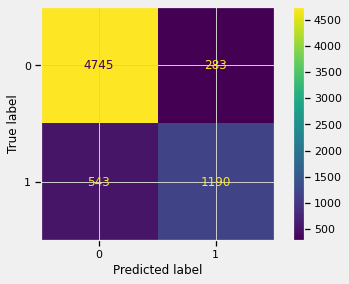

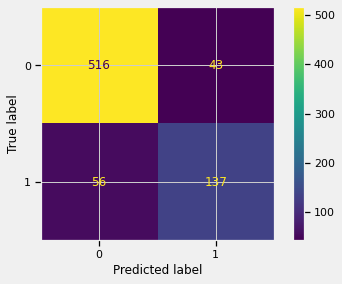

In [36]:
model.train()